# <center> Bicycle Counter Prediction </center>
## <center> Machine Learning for Life Science </center>

**<center> Jihwan Lim </center>**
    
<center> Supervised by Professor. Willem Waegeman </center>

*<center> 15-Nov-2023 </center>*

</div>

## 0 Introduction

This project aims to build a predictive model for number of bikes passing via Coupure Links considering various factors. 

To develop a predictive model that can accurately forecasts the number of bike various factors such as weather, date, time, and school schedule are used.

Not only 2023 bike data, but also 2022 data was collected for more precise prediction.

## Contents

**1. Data Collection**

**2. Feature Engineering**

**3. EDA (Exploratory Data Analysis)**

**4. Additional Feature Engineering**

**5. Model Selection**

**6. Final Submission**

**7. Future Work**

**8. Reference**

## 1 Data Collection

Data is pre-exlpored before loading using MS Excel to find out outlier data such as continual 0 value or negative value.

### 1.1 Import Library

Load all necessary libraries.

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#from sklearn.linear_model import Lasso
#from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFECV
%matplotlib inline

### 1.2 Load Bike Data

Load 2021, 2022, 2023 bike data.

All data was pre-processed:

- Data after July was already removed manually due to limited data (no after 2023 Aug)

In [90]:
def df_generator(file, start_date, end_date):
    train_data = pd.read_csv(file, sep = ';')
    total = []

    # Merge 5 minutes data to 1 hour data 
    for i in range(0,len(train_data),12):
        num = 0
        for j in range(12):
            num += train_data['Totaal'][i+j]
        total.append(num)

    data_df = {
        'date_hour': pd.date_range(start=start_date, end=end_date, freq='H'),
    }

    train_df = pd.DataFrame(data_df)
    train_df['Totaal'] = total
    train_df['Date_hour'] = train_df['date_hour'].dt.strftime('%Y-%m-%dT%H')
    train_df = train_df.drop('date_hour', axis = 1)

    return train_df

In [91]:
file2021 = './fietstelpaal-coupure-links-2021-gent.csv'
start_2021 ='2021-03-01T00:00'
end_2021 = '2021-07-31T23:00'

file2022 = './fietstelpaal-coupure-links-2022-gent.csv'
start_2022 = '2022-01-01T00:00'
end_2022 = '2022-07-31T23:00'

start_2023 = '2023-01-01T00:00'
end_2023 = '2023-07-31T23:00'

Make bike data as dataframe to implement

In [92]:
df_2021 = df_generator(file2021, start_2021, end_2021)
df_2022 = df_generator(file2022, start_2022, end_2022)

# # Load 2023 bike data (1-6, Given data)
file_2023 = './train_data.csv'
df_2023 = pd.read_csv(file_2023)

# Load testset (2023-07)
file_test = './test_data.csv'
testset = pd.read_csv(file_test)

### 1.2 Remove Outlier

There are some continuous 0 value data around 2023 Easter holiday. 

It can interfere the model training so they were removed.

In [93]:
# Drop from 2023-04-06 to 2023-04-18 data
start_mask = '2023-04-06T00'
end_mask = '2023-04-18T23'

mask = (df_2023['Date_hour'] >= start_mask) & (df_2023['Date_hour'] <= end_mask)

df_2023 = df_2023[~mask]
df_2023 = df_2023.reset_index(drop=True)
df_2023

,Date_hour,Totaal
0,2023-01-01T00,111.0
1,2023-01-01T01,201.0
2,2023-01-01T02,170.0
3,2023-01-01T03,144.0
4,2023-01-01T04,155.0
...,...,...
4026,2023-06-30T19,465.0
4027,2023-06-30T20,325.0
4028,2023-06-30T21,260.0
4029,2023-06-30T22,239.0


### 1.3 Load the weather data

Load all possible weather features:
- temperature_2m (°C)       
- relativehumidity_2m (%)
- dewpoint_2m (°C)
- apparent_temperature (°C)
- precipitation (mm)'
- rain (mm)
- snowfall (cm)
- snow_depth (m)
- cloud_cover (%)
- cloud_cover_low (%)
- cloud_cover_mid (%)
- cloud_cover_high (%)
- et0_fao_evapotranspiration (mm)
- vapour_pressure_deficit (kPa)
- windspeed_10m (km/h)
- windspeed_100m (km/h)
- winddirection_10m (°)
- winddirection_100m (°)
- is_day ()

Then leave features that could be affectable to bike number counted

In [94]:
#file_weather = './wather.csv' GMT+0
file_weather = './WeatherCET.csv' # Tiem zone CET is used
weather = pd.read_csv(file_weather, skiprows=2)

# Change the form of dataframe column as train data
weather["Date_hour"] = weather["time"].str.split(':', expand = True)[0]
#feature = weather.drop("time",axis =1) 

# Generate Feature tables
feature = weather.copy()
feature.set_index('Date_hour', inplace=True) # Set index same as train data to easily merge
feature.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,cloud_cover_mid (%),cloud_cover_high (%),et0_fao_evapotranspiration (mm),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h),is_day ()
Date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01T00,2021-01-01T00:00,-1.0,95,-1.6,-4.6,0.0,0.0,0.0,0.0,1,...,28,15,0.0,0.03,8.4,11.9,313,346,12.2,0
2021-01-01T01,2021-01-01T01:00,0.2,96,-0.4,-2.7,0.3,0.3,0.0,0.0,51,...,36,21,0.0,0.02,4.8,7.6,283,352,9.4,0
2021-01-01T02,2021-01-01T02:00,0.1,97,-0.4,-2.8,0.0,0.0,0.0,0.0,3,...,47,27,0.0,0.02,4.7,9.4,279,317,7.2,0
2021-01-01T03,2021-01-01T03:00,0.6,96,0.0,-2.5,0.0,0.0,0.0,0.0,2,...,44,52,0.0,0.02,6.9,17.1,279,298,11.9,0
2021-01-01T04,2021-01-01T04:00,0.9,95,0.2,-2.3,0.0,0.0,0.0,0.0,2,...,15,51,0.0,0.03,8.0,18.1,275,293,13.3,0


### 1.4 Data Normalization

Since 2021 was Covid-19 Pandemic season, tt should be normalized. 

To make 2022 data fit into 2023 data, it should be normalized as well.
- **Option 1:** Normalize it using total number of bike counted from Mar to Jun (2021 bike data starts from Mar & 2023 bike data ends at Jun)

- **Option 2:** Normalize it using mean number of bike counted of all month

In [95]:
def normlaizer(df):
    # Make copy not to harm original df
    df_copy = df.copy()

    # Transform to datetime object 
    df_copy['date_time'] = pd.to_datetime(df_copy['Date_hour']) 
    df_copy['date'] = df_copy['date_time'].dt.strftime('%Y-%m-%d')
    df_copy['month'] = pd.to_datetime(df_copy['date']).dt.month
    
    # Make a df with sum of each month
    result_df = df_copy.groupby('month')['Totaal'].sum().reset_index()

    return result_df['Totaal']

#### 1.4.1 Option 1

In [96]:
# Sum of number of bike between March and June
total_bike2021 = normlaizer(df_2021)[:-1].sum()
total_bike2022 = normlaizer(df_2022)[2:-1].sum()
total_bike2023 = normlaizer(df_2023)[2:].sum()
print(f'Total bike number 2021: {total_bike2021} \nTotal bike number 2022: {total_bike2022} \nTotal bike number 2023: {total_bike2023}')

Total bike number 2021: 750818 
Total bike number 2022: 934009 
Total bike number 2023: 943888.0


#### 1.3.2 Option 2

In [97]:
# Mean of number of bike
mean_bike2021 = normlaizer(df_2021).mean()
mean_bike2022 = normlaizer(df_2022).mean()
mean_bike2023 = normlaizer(df_2023).mean()
print(f'Mean bike number 2021: {mean_bike2021} \nMean bike number 2022: {mean_bike2022} \nMean bike number 2023: {mean_bike2023}')

Mean bike number 2021: 181271.4 
Mean bike number 2022: 205415.0 
Mean bike number 2023: 220169.16666666666


Since mean can consider all of the data in sepcific datasets, Mean normalized weight is chosen.

In [98]:
norm_2021_sum = total_bike2023/total_bike2021 
norm_2021_mean = mean_bike2023/mean_bike2021 # Most Reasonable

norm_2022_sum = total_bike2023/total_bike2022
norm_2022_mean = mean_bike2023/mean_bike2022 # Most Reasonable

print(f'Normalized weight for 2021 candidate 1: {norm_2021_sum} \nNormalized weight for 2021 candidate 2: {norm_2021_mean}')
print(f'Normalized weight for 2022 candidate 1: {norm_2022_sum} \nNormalized weight for 2022 candidate 2: {norm_2022_mean}')

Normalized weight for 2021 candidate 1: 1.2571462058714629 
Normalized weight for 2021 candidate 2: 1.2145830322194602
Normalized weight for 2022 candidate 1: 1.0105769858748685 
Normalized weight for 2022 candidate 2: 1.0718261405772054


#### 1.3.3 Normalization

Multiply normalized weight to each dataframe

In [99]:
df_2021['Totaal'] = df_2021['Totaal']*norm_2021_mean
df_2022['Totaal'] = df_2022['Totaal']*norm_2022_mean
print(df_2021.head())
print(df_2022.head())

      Totaal      Date_hour
0   6.072915  2021-03-01T00
1   1.214583  2021-03-01T01
2   0.000000  2021-03-01T02
3   2.429166  2021-03-01T03
4  25.506244  2021-03-01T04
       Totaal      Date_hour
0   32.154784  2022-01-01T00
1  117.900875  2022-01-01T01
2  125.403658  2022-01-01T02
3  158.630269  2022-01-01T03
4  160.773921  2022-01-01T04


### 1.4 Merge 

Merge all the dataframe for feature engineering

In [100]:
data_total = pd.concat([df_2021, df_2022, df_2023])
data_total = data_total.reset_index(drop=True)
data_total

,Totaal,Date_hour
0,6.072915,2021-03-01T00
1,1.214583,2021-03-01T01
2,0.000000,2021-03-01T02
3,2.429166,2021-03-01T03
4,25.506244,2021-03-01T04
...,...,...
12786,465.000000,2023-06-30T19
12787,325.000000,2023-06-30T20
12788,260.000000,2023-06-30T21
12789,239.000000,2023-06-30T22


## 2 Feature Engineering

Add or modify various features to help model learn better.

**Column check**

In [101]:
feature.columns

Index(['time', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)',
       'rain (mm)', 'snowfall (cm)', 'snow_depth (m)',
       'weather_code (wmo code)', 'pressure_msl (hPa)',
       'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)',
       'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'et0_fao_evapotranspiration (mm)', 'vapour_pressure_deficit (kPa)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)',
       'wind_direction_10m (°)', 'wind_direction_100m (°)',
       'wind_gusts_10m (km/h)', 'is_day ()'],
      dtype='object')

### 2.1 Add Date Features

From 'time' column, various features can be extracted:
- Weekday
- Month
- Day
- Hour

Based on those basic data, national holiday and workday (Mon-Fri, without nataional holiday) features could be added

In [102]:
# Transfrom pandas readable
feature['date_time'] = pd.to_datetime(feature['time']) 

#feature['year'] = feature['date_time'].dt.year

# Make columns of Mon - Sun: 0 - 6
feature['weekday'] = feature['date_time'].dt.dayofweek 

# Make month column: 1-12
feature['month'] = feature['date_time'].dt.month

# Make day column: 1-31
feature['day'] = feature['date_time'].dt.day 

# Make time column: 0-23
feature['hour'] = feature['date_time'].dt.hour 

# Belgian national holiday of 2023 
national_holidays = [
    '2023-01-01',  # New Year's Day
    #'2023-04-07',  # Good Friday
    #'2023-04-09',  # Easter Sunday
    '2023-04-10',  # Easter Monday
    '2023-05-01',  # Labour Day
    '2023-05-18',  # Ascension Day
    '2023-05-19',  # Day after Ascension Day
    '2023-05-29',  # Whit Monday
    '2023-07-21',  # Belgian National Day
    '2022-01-01',  # New Year's Day
    '2022-04-18',  # Easter Monday
    '2022-05-01',  # Labour Day
    '2022-05-26',  # Ascension Day
    '2022-06-06',  # Whit Monday
    '2022-07-21',  # Belgian National Day
    '2021-01-01',  # New Year's Day
    '2021-04-05',  # Easter Monday
    '2021-05-01',  # Labour Day
    '2021-05-13',  # Ascension Day
    '2021-05-24',  # Whit Monday
    '2021-07-21',  # Belgian National Day
]

# Make National holiday colum: Holiday as 1, non-holiday as 0
feature['date'] = feature['date_time'].dt.strftime('%Y-%m-%d')
feature['national_holiday'] = feature['date'].isin(national_holidays).astype(int)

# Add workingday Mon-Fri except for national holiday
feature['Workday'] = ((feature['weekday'] <= 4) & (feature['weekday'] >= 0) & (feature['national_holiday'] == 0)).astype(int)

# Result
feature.head()


,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,wind_gusts_10m (km/h),is_day (),date_time,weekday,month,day,hour,date,national_holiday,Workday
Date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01T00,2021-01-01T00:00,-1.0,95,-1.6,-4.6,0.0,0.0,0.0,0.0,1,...,12.2,0,2021-01-01 00:00:00,4,1,1,0,2021-01-01,1,0
2021-01-01T01,2021-01-01T01:00,0.2,96,-0.4,-2.7,0.3,0.3,0.0,0.0,51,...,9.4,0,2021-01-01 01:00:00,4,1,1,1,2021-01-01,1,0
2021-01-01T02,2021-01-01T02:00,0.1,97,-0.4,-2.8,0.0,0.0,0.0,0.0,3,...,7.2,0,2021-01-01 02:00:00,4,1,1,2,2021-01-01,1,0
2021-01-01T03,2021-01-01T03:00,0.6,96,0.0,-2.5,0.0,0.0,0.0,0.0,2,...,11.9,0,2021-01-01 03:00:00,4,1,1,3,2021-01-01,1,0
2021-01-01T04,2021-01-01T04:00,0.9,95,0.2,-2.3,0.0,0.0,0.0,0.0,2,...,13.3,0,2021-01-01 04:00:00,4,1,1,4,2021-01-01,1,0


### 2.3 Add School Schedule

Coupure Links Counter is located in front of UGent.

So suppose most people passing that street is students and other school (under high school and Arteveldehogeschool show similar schedule with UGent).

Since there was no information about 2021 and 2022 academic year, that schedule was guessed based on current academic schedule.

In [103]:
exam_start21 = '2021-01-09'
exam_start22 = '2022-01-10'
exam_start23 = '2023-01-11'

easter_start21 = '2021-04-03'
easter_start22 = '2022-04-02'
easter_start23 = '2023-04-01'

easter_end21 = '2021-04-19'
easter_end22 = '2022-04-19'
easter_end23 = '2023-04-17'

exam_end21 = '2021-07-09'
exam_end22 = '2022-07-08'
exam_end23 = '2023-07-07'

feature['educational_term'] = (((feature['date'] >= exam_start21 ) & (feature['date'] <= easter_start21))
                                |((feature['date'] >= exam_start22 ) & (feature['date'] <= easter_start22))
                                |((feature['date'] >= exam_start23 ) & (feature['date'] <= easter_start23))
                                |((feature['date'] >= easter_end21 ) & (feature['date'] <= exam_end21))
                                |((feature['date'] >= easter_end22 ) & (feature['date'] <= exam_end22))
                                |((feature['date'] >= easter_end23 ) & (feature['date'] <= exam_end23))).astype(int)

### 2.4 Penalizing educational term 

Introduce a penalization strategy for the **educational_term** feature, aimed at considering not only educational term but also workday (holiday and weekend).

In [104]:
feature['school_day'] = 1
feature['school_day'] = feature.apply(lambda row: row['school_day'] - 1/4 if row['educational_term'] != 1 else row['school_day'], axis=1)
feature['school_day'] = feature.apply(lambda row: row['school_day'] - 1/2 if row['Workday'] == 0 else row['school_day'], axis=1)

#feature['school_day'] = 0
#feature.loc[((feature['educational_term'] == 1) & (feature['Workday'] == 1)), 'school_day'] = 1
#feature.loc[(((feature['educational_term'] != 1) & (feature['Workday'] == 1)) | ((feature['educational_term'] == 1) & (feature['Workday'] != 1))), 'school_day'] = 0.5

### 2.5 Finalize adding features

In [105]:
feature.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,date_time,weekday,month,day,hour,date,national_holiday,Workday,educational_term,school_day
Date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01T00,2021-01-01T00:00,-1.0,95,-1.6,-4.6,0.0,0.0,0.0,0.0,1,...,2021-01-01 00:00:00,4,1,1,0,2021-01-01,1,0,0,0.25
2021-01-01T01,2021-01-01T01:00,0.2,96,-0.4,-2.7,0.3,0.3,0.0,0.0,51,...,2021-01-01 01:00:00,4,1,1,1,2021-01-01,1,0,0,0.25
2021-01-01T02,2021-01-01T02:00,0.1,97,-0.4,-2.8,0.0,0.0,0.0,0.0,3,...,2021-01-01 02:00:00,4,1,1,2,2021-01-01,1,0,0,0.25
2021-01-01T03,2021-01-01T03:00,0.6,96,0.0,-2.5,0.0,0.0,0.0,0.0,2,...,2021-01-01 03:00:00,4,1,1,3,2021-01-01,1,0,0,0.25
2021-01-01T04,2021-01-01T04:00,0.9,95,0.2,-2.3,0.0,0.0,0.0,0.0,2,...,2021-01-01 04:00:00,4,1,1,4,2021-01-01,1,0,0,0.25


## 3 EDA (Exploratory Data Analysis)

### 3.1 Merge 
Merge feature dataframe with bike number dataframe to explore.

In [106]:
def file_concater(bikefile, featurefile):
    # Make copy not to harm original df
    bikefile_copy = bikefile.copy()

    # Merge based on 'Date_hour'
    bikefile_copy.set_index('Date_hour', inplace=True)
    merged_file = bikefile_copy.merge(featurefile, on = "Date_hour")

    return merged_file

In [107]:
feature_select = file_concater(data_total,feature)

# To check whether overall bike number trend is similar to 2023
train_21 = file_concater(df_2021,feature) 
train_22 = file_concater(df_2022,feature)
train_23 = file_concater(df_2023,feature)

### 3.2 Distribution plot

Check data distribution with plot.

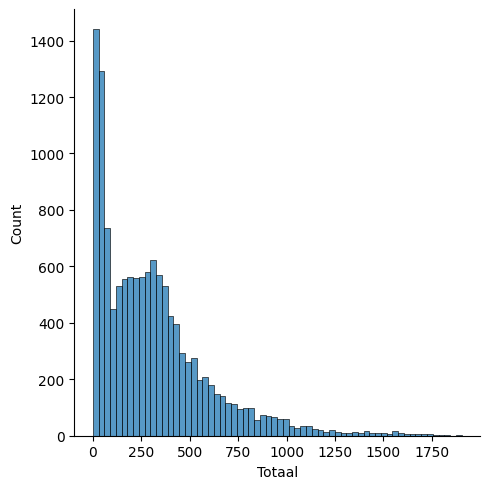

In [108]:
sns.displot(feature_select['Totaal']) # Very Skewed

### 3.3 Log normalization

To make it more normally distributed

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


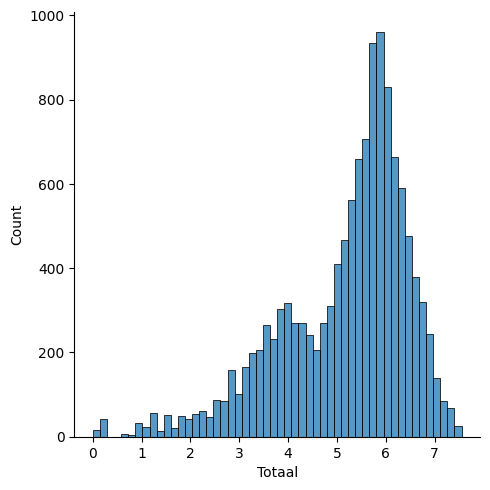

In [109]:
sns.displot(np.log(feature_select['Totaal'])) # Still skewed

### 3.4 Square root normalization

To make it more normally distributed

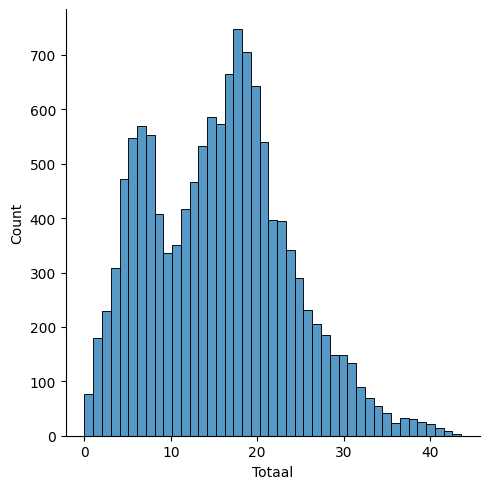

In [110]:
sns.displot(np.sqrt(feature_select['Totaal'])) # Looks like bimodal distribution but looks best

### 3.5 Visaulization

Plotting features to check features are reasonable or correlated with count number.

**Bar Plot**

[Text(0.5, 1.0, 'Box Plot On Total Across hour')]

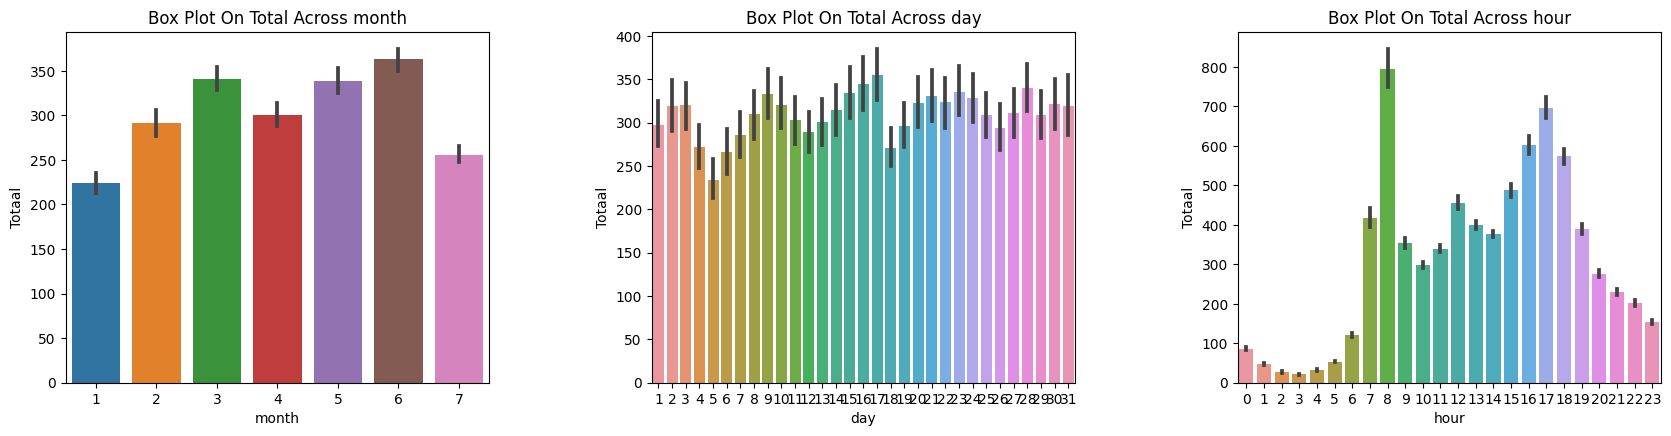

In [111]:
fig, axes = plt.subplots(ncols = 3)
plt.tight_layout()
fig.set_size_inches(18, 4)

sns.barplot(data = feature_select, x = 'month', y = 'Totaal', ax = axes[0])
sns.barplot(data = feature_select, x = 'day', y = 'Totaal', ax = axes[1])
sns.barplot(data = feature_select, x = 'hour', y = 'Totaal', ax = axes[2])

# Plot title
axes[0].set(title='Box Plot On Total Across month')
axes[1].set(title='Box Plot On Total Across day')
axes[2].set(title='Box Plot On Total Across hour')

**Point Plot 1**

All three datasets showing similar graph trends.

<Axes: xlabel='hour', ylabel='Totaal'>

<Figure size 640x480 with 0 Axes>

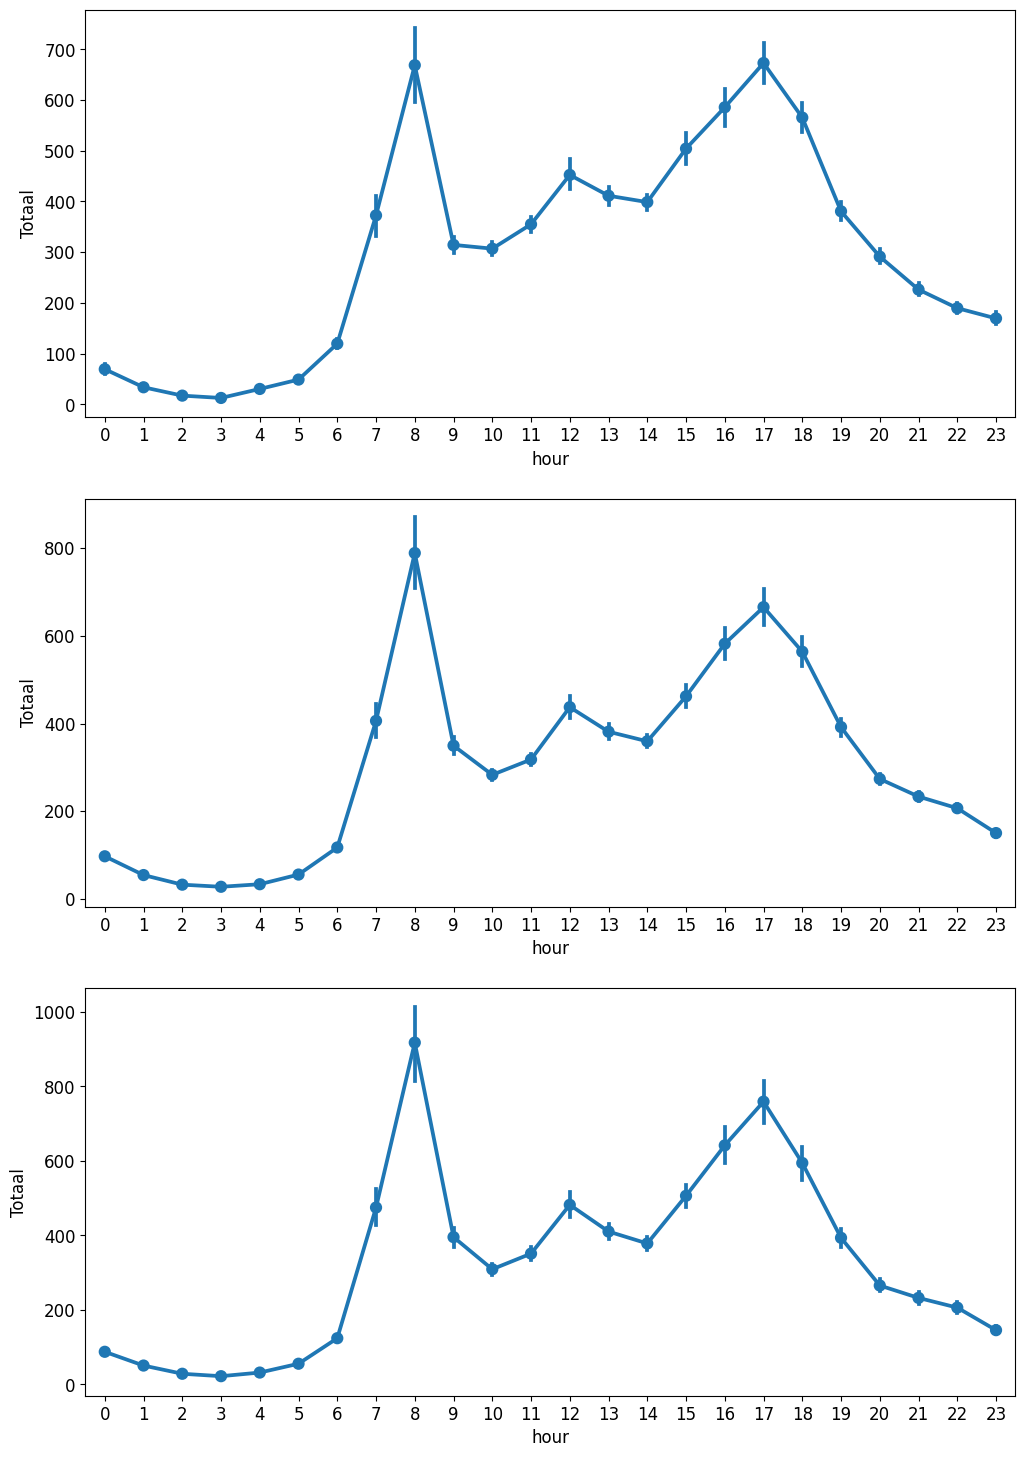

In [112]:
mpl.rc('font', size=12) 
plt.tight_layout()
figure, axes = plt.subplots(nrows=3) 
figure.set_size_inches(12, 18)

sns.pointplot(x='hour', y='Totaal', data=train_21, ax=axes[0])
sns.pointplot(x='hour', y='Totaal', data=train_22, ax=axes[1])
sns.pointplot(x='hour', y='Totaal', data=train_23, ax=axes[2])

**Point Plot 2**

Check engineered features are reasonable and well separated.

<Axes: xlabel='hour', ylabel='Totaal'>

<Figure size 640x480 with 0 Axes>

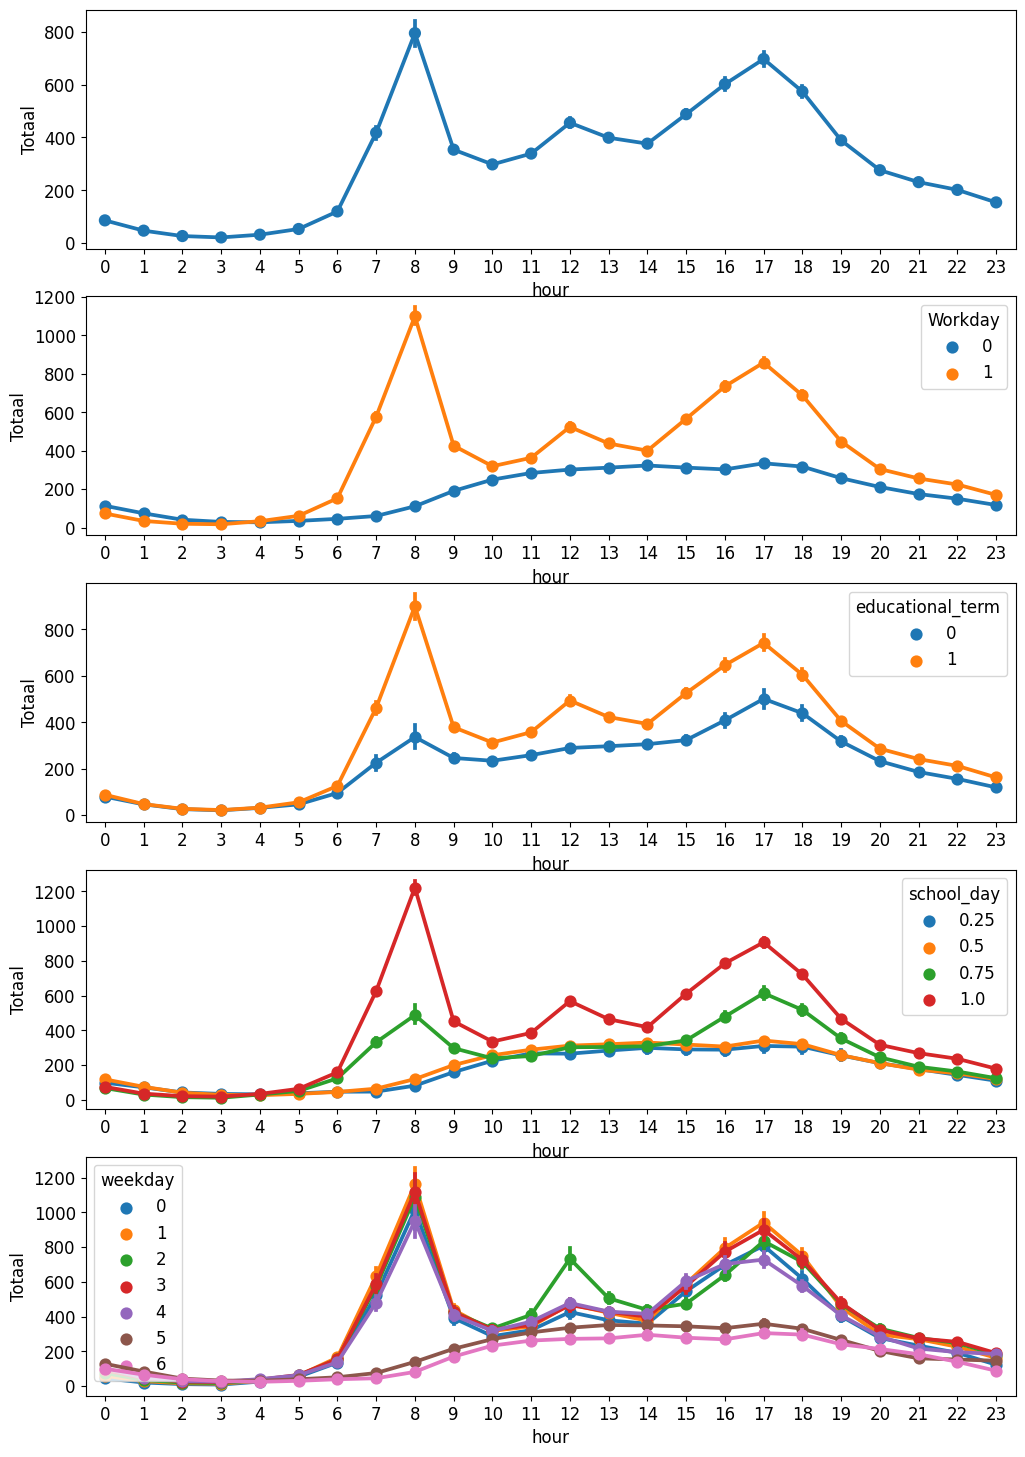

In [113]:
mpl.rc('font', size=12)
plt.tight_layout()
figure, axes = plt.subplots(nrows=5) 
figure.set_size_inches(12, 18)

sns.pointplot(x='hour', y='Totaal', data=feature_select, ax=axes[0])
sns.pointplot(x='hour', y='Totaal', data=feature_select, hue='Workday', ax=axes[1])
sns.pointplot(x='hour', y='Totaal', data=feature_select, hue='educational_term', ax=axes[2])
sns.pointplot(x='hour', y='Totaal', data=feature_select, hue='school_day', ax=axes[3])
sns.pointplot(x='hour', y='Totaal', data=feature_select, hue='weekday', ax=axes[4])

**Regression Plot 1**

To explore the correlation of numerical value data

<Axes: xlabel='wind_direction_100m (°)', ylabel='Totaal'>

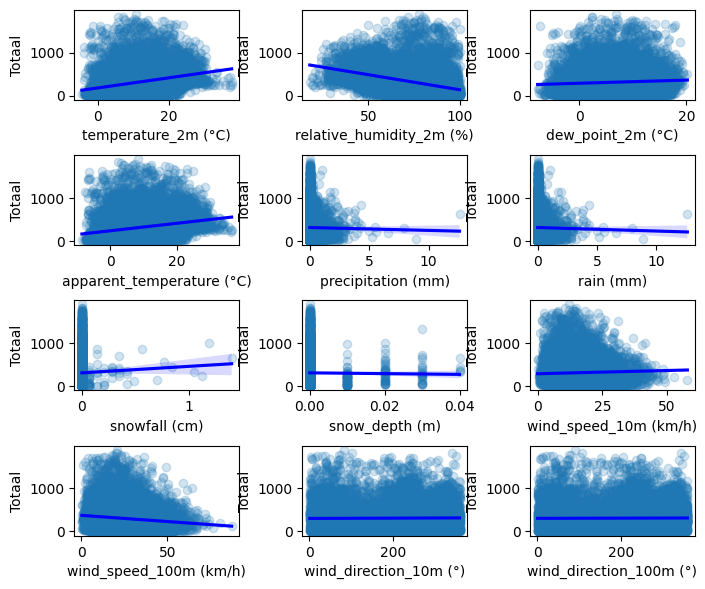

In [114]:
mpl.rc('font', size=10)
figure, axes = plt.subplots(nrows=4, ncols=3) 
plt.tight_layout()
figure.set_size_inches(7, 6)

sns.regplot(x='temperature_2m (°C)', y='Totaal', data=feature_select, ax=axes[0, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='relative_humidity_2m (%)', y='Totaal', data=feature_select, ax=axes[0, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='dew_point_2m (°C)', y='Totaal', data=feature_select, ax=axes[0, 2], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='apparent_temperature (°C)', y='Totaal', data=feature_select, ax=axes[1, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='precipitation (mm)', y='Totaal', data=feature_select, ax=axes[1, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='rain (mm)', y='Totaal', data=feature_select, ax=axes[1, 2], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='snowfall (cm)', y='Totaal', data=feature_select, ax=axes[2, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='snow_depth (m)', y='Totaal', data=feature_select, ax=axes[2, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='wind_speed_10m (km/h)', y='Totaal', data=feature_select, ax=axes[2, 2], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='wind_speed_100m (km/h)', y='Totaal', data=feature_select, ax=axes[3, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='wind_direction_10m (°)', y='Totaal', data=feature_select, ax=axes[3, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='wind_direction_100m (°)', y='Totaal', data=feature_select, ax=axes[3, 2], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})

**Regression Plot 2**

<Axes: xlabel='is_day ()', ylabel='Totaal'>

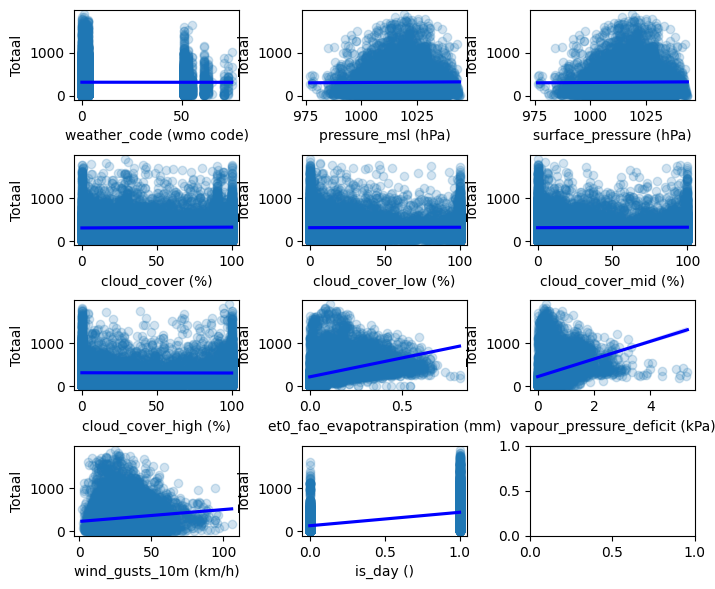

In [115]:
mpl.rc('font', size=10)
figure, axes = plt.subplots(nrows=4, ncols=3) 
plt.tight_layout()
figure.set_size_inches(7, 6)

sns.regplot(x='weather_code (wmo code)', y='Totaal', data=feature_select, ax=axes[0, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='pressure_msl (hPa)', y='Totaal', data=feature_select, ax=axes[0, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='surface_pressure (hPa)', y='Totaal', data=feature_select, ax=axes[0, 2], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='cloud_cover (%)', y='Totaal', data=feature_select, ax=axes[1, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='cloud_cover_low (%)', y='Totaal', data=feature_select, ax=axes[1, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='cloud_cover_mid (%)', y='Totaal', data=feature_select, ax=axes[1, 2], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='cloud_cover_high (%)', y='Totaal', data=feature_select, ax=axes[2, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='et0_fao_evapotranspiration (mm)', y='Totaal', data=feature_select, ax=axes[2, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='vapour_pressure_deficit (kPa)', y='Totaal', data=feature_select, ax=axes[2, 2], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='wind_gusts_10m (km/h)', y='Totaal', data=feature_select, ax=axes[3, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='is_day ()', y='Totaal', data=feature_select, ax=axes[3, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})

**Correlation Matrix**

It is hard to analyze the data using regplot so make it as matrix and heatmap.

In [116]:
corrMat = feature_select[['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)',
       'rain (mm)', 'snowfall (cm)', 'snow_depth (m)',
       'weather_code (wmo code)', 'pressure_msl (hPa)',
       'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)',
       'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'et0_fao_evapotranspiration (mm)', 'vapour_pressure_deficit (kPa)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)',
       'wind_direction_10m (°)', 'wind_direction_100m (°)',
       'wind_gusts_10m (km/h)', 'is_day ()','Totaal']].corr()

corrMat

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),pressure_msl (hPa),...,cloud_cover_high (%),et0_fao_evapotranspiration (mm),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h),is_day (),Totaal
temperature_2m (°C),1.000000,-0.568222,0.819308,0.985308,0.032536,0.039912,-0.061526,-0.110919,-0.001964,-0.204087,...,0.116548,0.679909,0.772869,-0.001156,-0.145045,-0.003384,-0.017170,0.111607,0.409959,0.275562
relative_humidity_2m (%),-0.568222,1.000000,-0.005804,-0.479254,0.134348,0.132256,0.029087,0.020791,0.171840,0.008667,...,0.080131,-0.788135,-0.851278,-0.122602,0.038580,0.140845,0.147159,-0.245052,-0.452397,-0.398367
dew_point_2m (°C),0.819308,-0.005804,1.000000,0.861015,0.132709,0.140532,-0.057308,-0.122518,0.123217,-0.249472,...,0.201367,0.266015,0.311649,-0.063096,-0.128762,0.099290,0.085922,-0.007286,0.199728,0.067224
apparent_temperature (°C),0.985308,-0.479254,0.861015,1.000000,0.030887,0.038803,-0.066360,-0.115498,-0.022892,-0.153611,...,0.113857,0.630442,0.717883,-0.147508,-0.275258,-0.013333,-0.027608,-0.034313,0.374905,0.241809
precipitation (mm),0.032536,0.134348,0.132709,0.030887,1.000000,0.993497,0.137573,0.044815,0.558831,-0.233459,...,0.169521,-0.043733,-0.089395,0.134030,0.118105,0.067066,0.067461,0.166672,0.056129,-0.008267
rain (mm),0.039912,0.132256,0.140532,0.038803,0.993497,1.000000,0.023902,0.022400,0.546951,-0.228657,...,0.171165,-0.041424,-0.086727,0.130111,0.113843,0.067467,0.067684,0.163199,0.055269,-0.010050
snowfall (cm),-0.061526,0.029087,-0.057308,-0.066360,0.137573,0.023902,1.000000,0.198624,0.148610,-0.060680,...,-0.000568,-0.023632,-0.030453,0.044943,0.046644,0.001944,0.003520,0.043712,0.012027,0.014842
snow_depth (m),-0.110919,0.020791,-0.122518,-0.115498,0.044815,0.022400,0.198624,1.000000,0.078426,-0.120922,...,0.025641,-0.036608,-0.049351,0.034308,0.029612,-0.073720,-0.069586,0.032229,0.000195,-0.006164
weather_code (wmo code),-0.001964,0.171840,0.123217,-0.022892,0.558831,0.546951,0.148610,0.078426,1.000000,-0.365611,...,0.216535,-0.048130,-0.143383,0.286210,0.238180,0.179345,0.182193,0.321829,0.102971,-0.001925
pressure_msl (hPa),-0.204087,0.008667,-0.249472,-0.153611,-0.233459,-0.228657,-0.060680,-0.120922,-0.365611,1.000000,...,-0.282607,-0.020779,-0.054356,-0.414348,-0.400247,-0.164637,-0.168473,-0.430617,-0.038050,0.010557


**HeatMap**

Some features (considering only > 0.2 toward label) show similar trends toward bike count.

- **apparent_temperature (°C)** & **temperature_2m (°C)**

- **et0_fao_evapotranspiration (mm)**, **vapour_pressure_deficit (kPa)**, &	**relative_humidity_2m (%)** (negatively)

Due to Multicollinearity, these features can interfere model training.

[Text(0.5, 1.0, 'Heatmap of Numerical Data')]

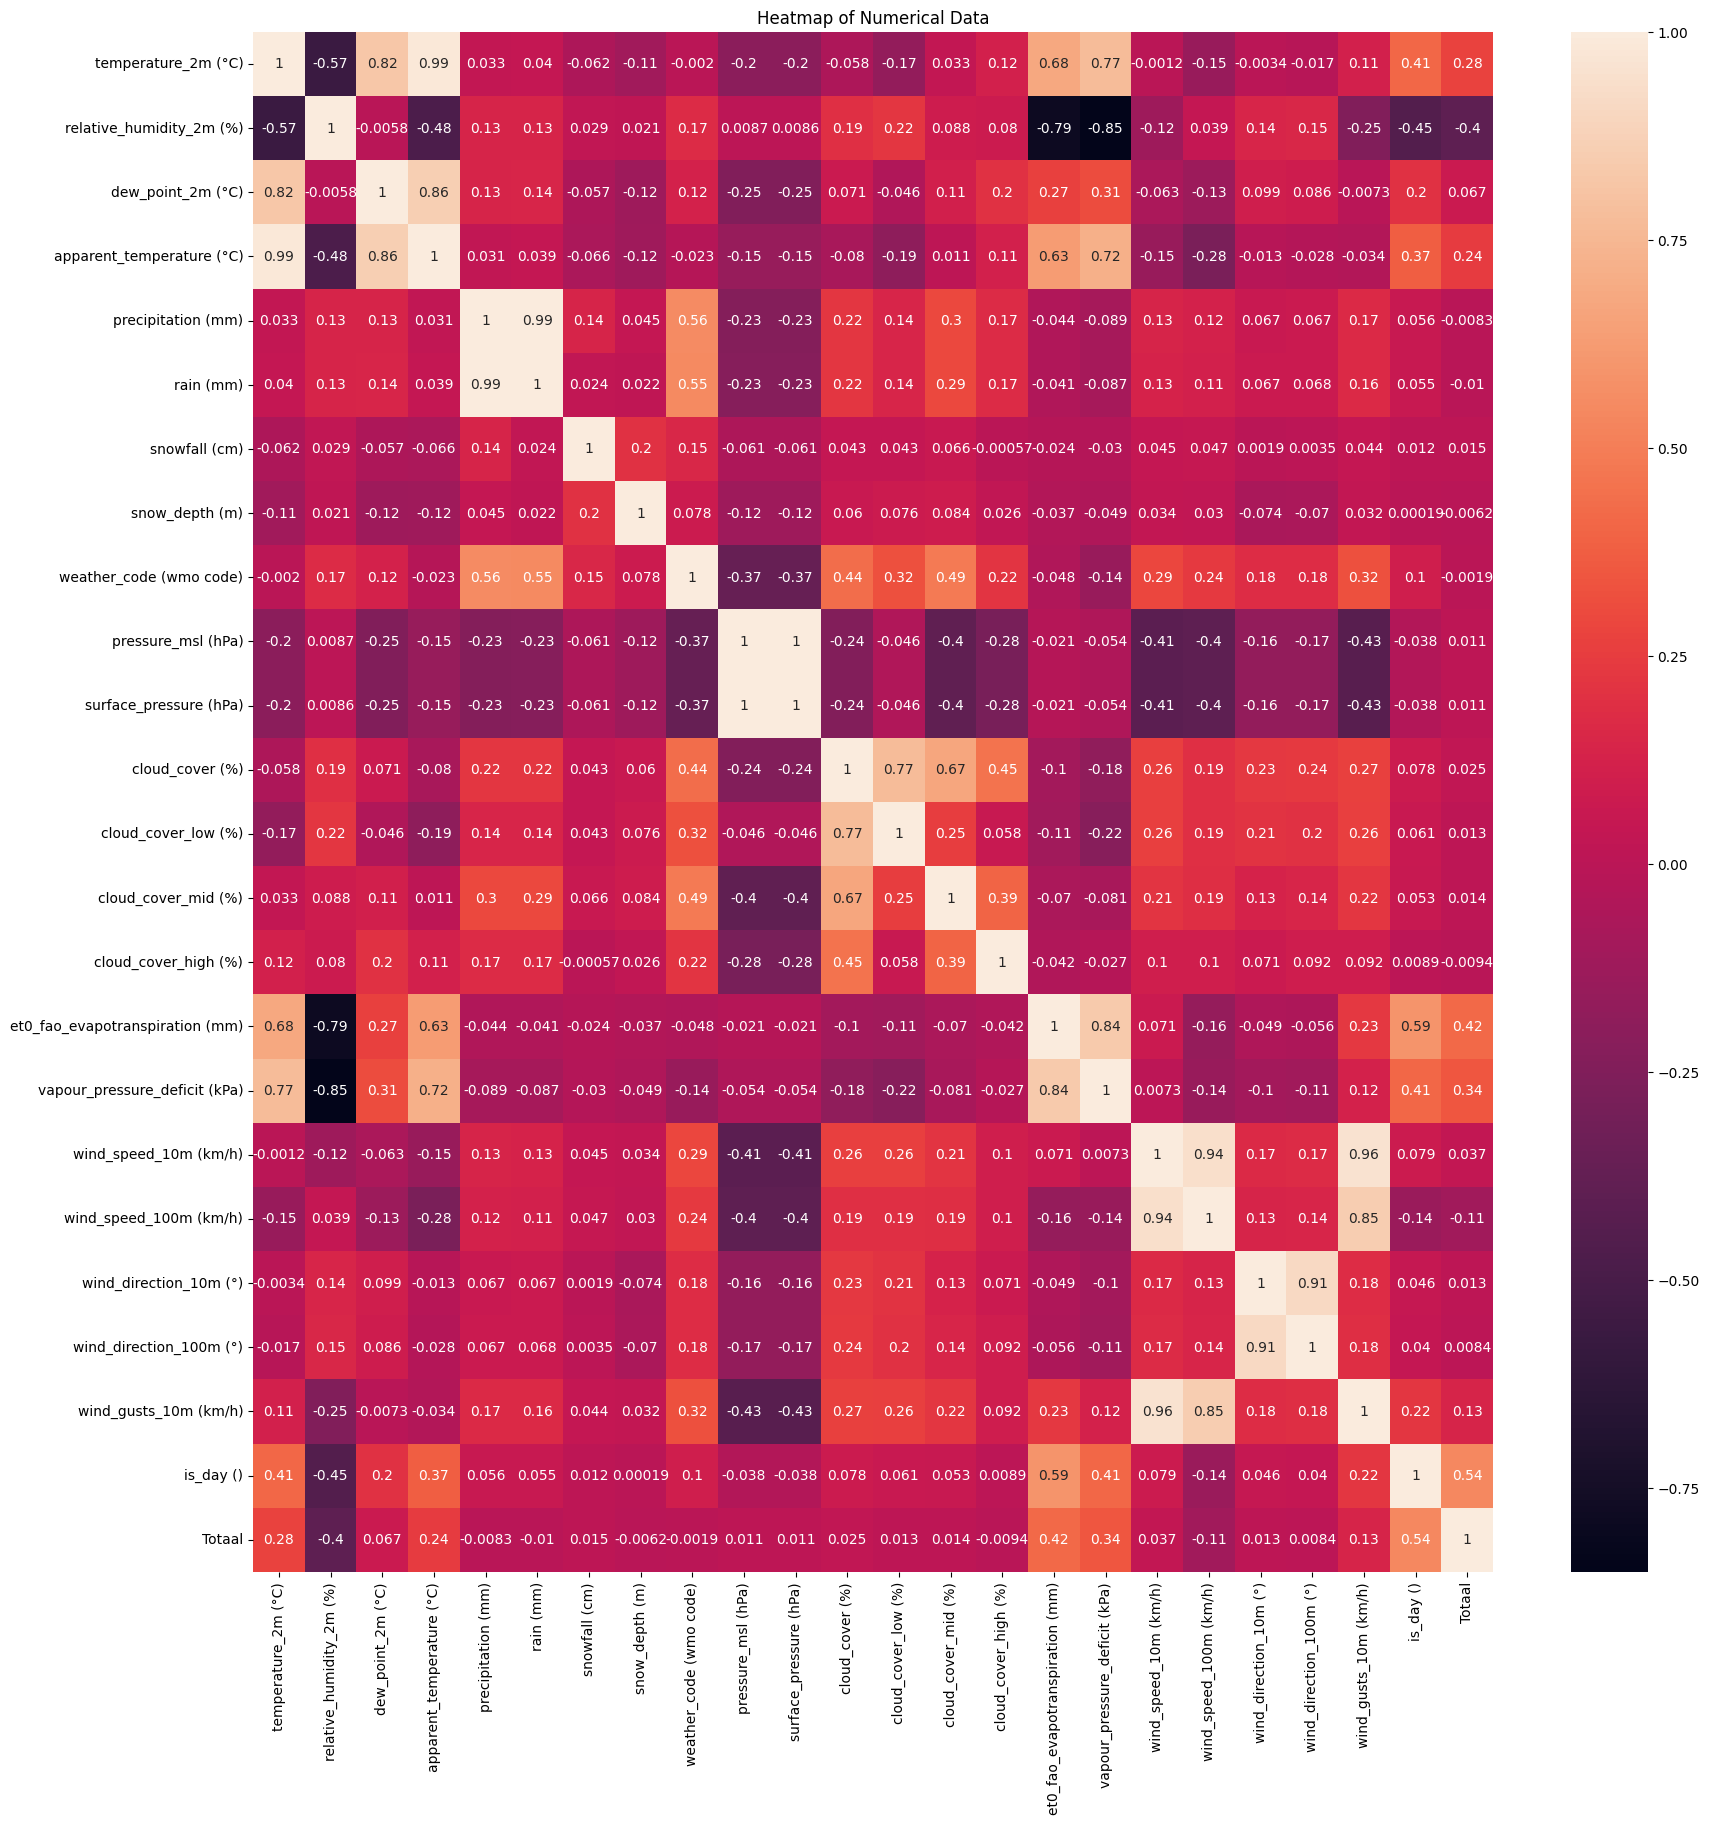

In [117]:
fig, ax= plt.subplots() 
fig.set_size_inches(20, 20)
sns.heatmap(corrMat, annot=True, annot_kws={"size": 10})
ax.set(title='Heatmap of Numerical Data')

## 4 Additional Feature Engineering

Creating new features based on temporal patterns observed in the data, particularly focusing on variations in bike number across different hours.

### 4.1 Add Working Hour & Commute Time

Based on point plot (total-hour), there is two main peaks at 8 AM and 17 PM.

In [118]:
# Working hour
feature['working_hour'] = ((feature['hour'] >= 8) & (feature['hour'] <= 17)).astype(int)

# Make columns for comute time 
feature['go_to_work'] = (feature['hour'] == 8).astype(int) # going to work
feature['go_to_home'] = (feature['hour'] == 17).astype(int) # coming back to work
feature['commute_time'] = ((feature['hour'] == 8) | (feature['hour'] == 17)).astype(int) # Combine commute time

### 4.2 Penalize Commute Time

Introduce a penalization strategy for the **commute_time** feature, aimed at differentiating peak and off-peak hours in terms of bike number. 

The value decreases gradually from 1 at 8 AM to 0 during the least busy hours. 

In [119]:
feature['commute_time_pen'] = 0  # Set all values as 0

feature.loc[(feature['hour'] == 8), 'commute_time_pen'] = 1 # Peak time

feature.loc[(feature['hour'] == 17), 'commute_time_pen'] = 0.8 # Second peak time

feature.loc[(feature['hour'] == 16) | (feature['hour'] == 18) , 'commute_time_pen'] = 0.6

feature.loc[(feature['hour'] == 7)| ((feature['hour'] >= 9) & (feature['hour'] <= 15)) | (feature['hour'] == 19), 'commute_time_pen'] = 0.4

### 4.3 Mathematical Penalization of Commute Time

This approach is from understanding of bike usage patterns across different hours of the day.

Adopt a normalization technique where the mean number of bikes for each hour is divided by the mean number at 8 AM (the peak time). 

- Formula: **commute_time_pen2** = **Mean Bikes per Hour** / **Mean Bikes at 8 AM**

In [120]:
result = feature_select.groupby('hour')['Totaal'].mean().reset_index()
result['commute_pen2'] = result['Totaal']/result['Totaal'].max() # result['Totaal'].max(): # 8 AM bike 

# Make a dictionary hour as key and mean number as value
commute_dict = {} 
for i in range(len(result)):
    commute_dict[result['hour'].iloc[i]] = result['commute_pen2'].iloc[i]

# Add feature
feature['commute_time_pen2'] = feature['hour'].map(commute_dict)
feature.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,national_holiday,Workday,educational_term,school_day,working_hour,go_to_work,go_to_home,commute_time,commute_time_pen,commute_time_pen2
Date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01T00,2021-01-01T00:00,-1.0,95,-1.6,-4.6,0.0,0.0,0.0,0.0,1,...,1,0,0,0.25,0,0,0,0,0.0,0.108335
2021-01-01T01,2021-01-01T01:00,0.2,96,-0.4,-2.7,0.3,0.3,0.0,0.0,51,...,1,0,0,0.25,0,0,0,0,0.0,0.059387
2021-01-01T02,2021-01-01T02:00,0.1,97,-0.4,-2.8,0.0,0.0,0.0,0.0,3,...,1,0,0,0.25,0,0,0,0,0.0,0.033723
2021-01-01T03,2021-01-01T03:00,0.6,96,0.0,-2.5,0.0,0.0,0.0,0.0,2,...,1,0,0,0.25,0,0,0,0,0.0,0.027080
2021-01-01T04,2021-01-01T04:00,0.9,95,0.2,-2.3,0.0,0.0,0.0,0.0,2,...,1,0,0,0.25,0,0,0,0,0.0,0.040255


### 4.4 Combination of Time and Date Features

Strategic combination of time and date features to enhance the predictive power of our model. 

Integrating **commute_time_pen2** and **school_day**

- Objective: Aim is to develop a model that simultaneously considers both features.

- Approach: Based on EDA, where **commute_time_pen2** and **school_day** exhibit varying degrees of influence on bike count patterns.

- Formula: **comb** = **commute_time_pen2** + **school_day**/4

The exact weight factor is determined through a process of trial and error.

In [121]:
feature['comb'] = feature['commute_time_pen2'] + feature['school_day']/4 # trial & error to select

### 4.5 Remove Weather Features

Streamlining features by removing weather-related features that show minimal correlation with target variable.

- Criteria for Removal: Specifically target weather features with a correlation of less than 0.3 with count number variable.

In [122]:
feature = feature.drop(['dew_point_2m (°C)',  'precipitation (mm)', 'surface_pressure (hPa)',
       'rain (mm)', 'snowfall (cm)', 'snow_depth (m)',
       'weather_code (wmo code)', 'pressure_msl (hPa)',
       'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)', 'is_day ()', 
       'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'apparent_temperature (°C)', 'temperature_2m (°C)',
       'wind_direction_10m (°)', 'wind_direction_100m (°)','wind_gusts_10m (km/h)'], axis=1)

### 4.6 Remove Auxilary Features 

Eliminating auxilary features that have limited informational value or are redundant due to other more comprehensive features.

Simplifying Time-Related Features
- Go to home and work:

    - Original Features: **go_to_work** (8 AM bike data) and **go_to_home** (5 PM bike data).

    - Rationale: These features offer a narrow snapshot of bike usage and are already encapsulated within the **commute_time_pen2**.

* National holiday:

    - Original Feature: **national_holiday** (data specific to national holidays).

    - Rationale: The essence of this feature is better captured in the **workday**.

Streamlining Commute Time Features
- Commute time:

    - Original Features: **commute_time** and **commute_time_pen**.

    - Observation: **commute_time_pen** was generated in a biased and artificial manner.

    - Rationale: Decide to use **commute_time_pen2**, which offers a more balanced representation of commute times and potentially incorporates the insights from **commute_time_pen**.

Refactoring Date and Time Features
- Date and Time

    - Original Features: **date**, **date_time**, and  **time**
    
    - Rationale: These features were primarily useful during the feature engineering phase and no longer neacessary for training.

By removing these auxiliary features, enhance the model's focus on more impactful variables. 

In [123]:
feature = feature.drop(['go_to_work','go_to_home','national_holiday','commute_time','commute_time_pen'], axis =1) 
feature = feature.drop(['date','date_time','time'], axis =1) 
feature.head() # Finalize feature selection

,relative_humidity_2m (%),et0_fao_evapotranspiration (mm),vapour_pressure_deficit (kPa),weekday,month,day,hour,Workday,educational_term,school_day,working_hour,commute_time_pen2,comb
Date_hour,,,,,,,,,,,,,
2021-01-01T00,95,0.0,0.03,4,1,1,0,0,0,0.25,0,0.108335,0.170835
2021-01-01T01,96,0.0,0.02,4,1,1,1,0,0,0.25,0,0.059387,0.121887
2021-01-01T02,97,0.0,0.02,4,1,1,2,0,0,0.25,0,0.033723,0.096223
2021-01-01T03,96,0.0,0.02,4,1,1,3,0,0,0.25,0,0.027080,0.089580
2021-01-01T04,95,0.0,0.03,4,1,1,4,0,0,0.25,0,0.040255,0.102755


## 5 Model Selection

### 5.1 Merge Bike Data

Merge 2022 and 2023 bike data, excluding 2021 bike data.

Rtionale:
- Incomplete Data: 2021 bike data lacks for  information for January and February, making it less representative.

- Normalization Issues: Disproportionately large normalized weights in the 2021 data, which can harm original 2021 data.

- Bias: Since 2021 was COVID-19 pandemic season, data could be biased.

&#8251; Selection is based on Trial & Error and above Rationale and Kaggle score.

In [124]:
data_total = pd.concat([df_2022, df_2023])
trainset = data_total.reset_index(drop=True)

### 5.2 Merge Feature with Bike Data

Merge trainset and testset with selected features.

In [125]:
train_data = file_concater(trainset,feature)
test_data = file_concater(testset, feature)

test_data.set_index('Id', inplace=True) # For making submission file

### 5.3 Remove Outlier

Remove outliers (too big or too small bike number) at each time point (hour).

If outlier removal is performed on the entire dataset, it may harm important data such as 8 am or 17 pm data.

At most of the time point, the number of bike uder q1 - 1.5*iqr is negative value, so just remove 0. 

Too much removal of outlier might lead overfitting, so oprimized by trial & error camparing both mean CV score and actual score (Kaggle).

In [126]:
time_df = train_data.groupby('hour')

out_list = []
for i in range(24):
    
    grouped_time = time_df.get_group(i)
    q1 = grouped_time['Totaal'].quantile(0.25)
    q3 = grouped_time['Totaal'].quantile(0.75)

    iqr=q3-q1

    condition = ((grouped_time['Totaal'] >= q3 + 1.5*iqr) | (grouped_time['Totaal'] <= 0)) # At most of the time point, q1 - 1.5*iqr is under 0, 
    out_list += list(grouped_time[condition].index)
print('Removed Outliers: ',len(out_list))
train_data.drop(out_list,inplace=True)

# Make train data learnable
y = train_data['Totaal']
x = train_data.drop('Totaal', axis=1).values

Removed Outliers:  77


### 5.4 Model Selection

#### 5.4.1 Selection Rationale

#### GridSearchCV:

- Hyperparmeter Selection: Look for all possible combination of given hyperparameters, so best parameter can be found. 

    - First, hyperparameter range is rougly selected using RandomizedSearchCV.

    - Then, optimized by trial & error gradually increasing or decreasing the range of hyperparamter.

- Cross Validation: By using K-fold cross validation, overfitting is prevented and the best model could be selected with mean evaluation score.

- Simplicity: Easy to implement.

#### Extreme Gradient Boosting (XGB):

- Effective in handling non-linear and complex data.

- One of most gnenrally used predictive models for competition (i.e. Kaggle) or industry.

- Prevent overfitting with their built-in regularization function.

- Best Performance: XGB outperforms comaperd to other models (RandomForest, Lasso, and other linear models).

    **Lasso:**

    - 21,22,23: 0.7600355457070049

    - 22,23 : 0.7480903959981268

    **RandomForest Regressor:**

    - 21,22,23: 0.9077374313591565

    - 22,23 : 0.9113080018938456 / 0.9129 (Kaggle)

    **XGBoost Regressor:**

    - 21,22,23: 0.9479848801424333 / 0.9126 (Kaggle)
    
    - 22,23 : 0.9512018529374817 / 0.9346 (Kaggle) **Bset!!**

### 5.5 Training Extreme Gradient Boosting (XGB) Regressor

Traing selected model based on the best mean CV score and Kaggle score.

In [127]:
xgb_model = xgb.XGBRegressor()

# Parameter range is optimized by trial & error
param = {
    'n_estimators': [120, 160, 250],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1],
    'max_depth': [7, 8, 10],
    'lambda' : [1, 2, 4],
    'alpha': [1, 2],
    'random_state': [42]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42) # To use same cross-validation contents for every test

# Use same scoring method as Kaggle & Use all possble cores to make it fast 
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param, cv=kfold, scoring='r2', n_jobs=-1) 
grid_search_xgb.fit(x, np.sqrt(y)) # Sqaure Root of label values to normalize, should be squared after prediction

best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_params = grid_search_xgb.best_params_
best_xgb_score = grid_search_xgb.best_score_ # Mean score by best model using k-fold cv

print("Best Parameter:", best_xgb_params)
print("Best Score:", best_xgb_score)

#preds = best_xgb_model.predict(test_data)

#submission_xgb = pd.DataFrame(np.square(preds))
#submission_file_xgb = pd.DataFrame([testset["Id"]]).T
#submission_file_xgb['Predicted'] = list(submission_xgb[0])
#submission_file_xgb.to_csv("submission_.csv", index = False)

Best Parameter: {'alpha': 1, 'colsample_bytree': 0.7, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250, 'random_state': 42}
Best Score: 0.9512018529374817


### 5.6 List Feature Importance

Explore features that can be potentally removed with sorting by importances of features.

In [128]:
# Get feature importances
feature_importance = best_xgb_model.feature_importances_
feature = pd.DataFrame(feature_importance)

index = test_data.columns
feature['index'] = index

# Sorting features
sorted_df = feature.sort_values(by=0, ascending=False)
sorted_df

,0,index
10,0.345925,working_hour
9,0.178152,school_day
11,0.162162,commute_time_pen2
12,0.157656,comb
7,0.078845,Workday
6,0.025443,hour
1,0.013670,et0_fao_evapotranspiration (mm)
8,0.010015,educational_term
4,0.009470,month
3,0.006671,weekday


### 5.7 Recursive Feature Elimination CV

Using Recursive Feature Elimination to cross check whether there is usless feature or not.

In [129]:
rfexgb = RFECV(estimator=best_xgb_model, cv=kfold, scoring='r2')

X_rfexgb = rfexgb.fit(x, np.sqrt(y))

feature_key = list(train_data.columns[1:])
feature_value = list(X_rfexgb.support_)
feature_dict = {}

# Make a dict with feature name as key and True or False as value (If eliminable feature, False)
for i in range(len(feature_key)):
    feature_dict[feature_key[i]] = feature_value[i]

removable_featurelist = []
# Find False returning features
for i in feature_dict:
    if not feature_dict[i]:
        removable_featurelist.append(i)

removable_featurelist

['relative_humidity_2m (%)']

## 6. Final Submission

Re-Trin, Predict, and Submit.

### 6.1 Final Feature Removal

Find best feature sets by trial & error based on feature impoortance table and result of RFECV.

In [130]:
# Remove features to make best score
train_data_final = train_data.drop(['relative_humidity_2m (%)','et0_fao_evapotranspiration (mm)'], axis=1)
test_data_final = test_data.drop(['relative_humidity_2m (%)','et0_fao_evapotranspiration (mm)'], axis=1)

y_final = train_data_final['Totaal']
x_final = train_data_final.drop('Totaal', axis=1).values

### 6.2 Re-Train Model

Train model with final features.

In [131]:
grid_search_xgb_final = GridSearchCV(estimator=xgb_model, param_grid=param, cv=kfold, scoring='r2', n_jobs=-1)
grid_search_xgb_final.fit(x_final, np.sqrt(y_final))

best_xgb_model_final = grid_search_xgb_final.best_estimator_
best_xgb_params_final = grid_search_xgb_final.best_params_
best_xgb_score_final = grid_search_xgb_final.best_score_

print("Best Parameter:", best_xgb_params_final)
print("Best Score:", best_xgb_score_final)

Best Parameter: {'alpha': 2, 'colsample_bytree': 0.5, 'lambda': 4, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250, 'random_state': 42}
Best Score: 0.9549170295885366


### 6.3 Predict & Submit

Finally, predict the number of bike for July 2023 using selected and optimized model.

Prepare a submission file based on the model's predictions.

Prioritize achieving a high Kaggle score rather than best mean CV score itself, while making sure that the model is not overfitted to the July 2023 data.

In [132]:
# Final Prediction with unseen data
preds_final = best_xgb_model_final.predict(test_data_final)

# Sqaure the values to make it original
submission_xgb_final = pd.DataFrame(np.square(preds_final))
submission_file_final = pd.DataFrame([testset["Id"]]).T
submission_file_final['Predicted'] = list(submission_xgb_final[0])
submission_file_final.to_csv("submission_final.csv", index = False)

Get **0.9372** score as final score!

## 7 Future Work

**1. Time Limitness:**

- If there is more enough time to optimize my features and model, model performance would be slightly better.

**2. Optimizing the Features:**

- Weighting of **school_day** feature is not so accurate, so if possible, use more sophisticated techniques for encoding this feature.

- More temporal features like Lunch time, Dinner time, or the Friday (a lot of students go back to their home) is not considered, should think about more complex features that can represent bike number.

**3. Optimizing the Parameters:**

- More various hyperparameters and their range could be implemented if there is more enough time.

- *subsample*, *min child weight*, and etc. could be optimized when using XGB model. 

**4. Bike Parking Information:**

- There is a limitness of acquiring bike data since Stad Gent data portal only provides real-time bike parking data of Korenmarkt &  Braunplein.

- If historical bike parking data of campus Coupure or near Coupure Links are provided, model could be improved.

**5. Incorporating Public Event Schedules:**

- Integrating more information about public event schedules (i.e. 2023 Gentse Feesten, Marathon), model could catch the features better.

**6. Easter Holiday:**

- 2023 data lacks of easter holiday bike number, and I don't know how long other institution (comapny or other school) except for UGent take off during easter holiday.

- Lack of insights about easter holiday, since last year was my first easter holiday.

**7. Restricted Data:**

- If more abundunt datasets are provided, model can be upgraded to predict other months not only for July 2023.

## 8 Reference

All the data and information can be found this reference list.

- [**Public Holiday**](https://publicholidays.be/2022-dates/)

- [**Why is Random State always 42?**](https://grsahagian.medium.com/what-is-random-state-42-d803402ee76b)

- [**Stad Gent Data Portal**](https://data.stad.gent/explore/?disjunctive.keyword&disjunctive.theme&sort=modified)

- [**School Schedule**](https://schoolholidayseurope.eu/school-holidays-belgium/#google_vignette)

- [**UGENT Academic Year**](https://www.ugent.be/student/en/class-exam-exchange-intern/class-exam/academiccalendar/academic-calendar-2022-2023.htm)

- [**Weather Data**](https://open-meteo.com/en/docs/historical-weather-api#latitude=51.05354799168703&longitude=3.709189838702975&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,is_day&timezone=auto)

